## Problem 2.4
####  In this problem, we analyze single-cell RNA-seq data and determine structure in this high-dimensional
#### data. The data set consists of 272 cells, each corresponding to a column. Each row corresponds
#### to the RNA-seq measurements of a particular genomic feature. Each entry corresponds to the
#### normalized transcript compatibility count (TCC) of the feature. The TCC counts the number of
#### reads of sequences which are compatible with each genomic feature for a given cell. The entries have been normalized so that #### each column in the matrix sums to 1. The data for this problem can
#### be found in \Trapnell.csv." Note: this data has 1,065,024 rows, so the built-in csv-reader functions
#### in R/numpy may be very slow. You may want to look for alternatives.

#### (a) Determine cell clusters by applying k-means clustering to the data. Hint: it may be helpful to
#### first apply a dimension reduction method such as tSNE or PCA. This will help you determine
#### the correct number of clusters to use and can speed up computations.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [1]:
#Import needed packages 
import dask.dataframe as dd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
import pylab as pl
import networkx as nx


In [22]:
time_start = time.time()

df = pd.read_csv(r'C:\Users\kalib\Documents\IDS.131\Pset 2\trapnell.csv', sep=',')

print('Data loading into Dataframe is done Time elapsed {}'.format(time.time()-time_start))

Data loading into Dataframe is done Time elapsed 24.23851728439331


In [3]:
df.shape

(1065023, 272)

In [23]:
#Expects samples to be rows, 

time_start = time.time()
df_transpose = df.T
print(df_transpose.shape)
print('Transposing data is done Time elapsed {}'.format(time.time()-time_start))

(272, 1065023)
Transposing data is done Time elapsed 0.028508424758911133


In [7]:
# Apply PCA to determine how many Principle Components are needed to define the data
time_start = time.time()

pca_trapnell = PCA(n_components= 20)
principalComponents_Trapnell = pca_trapnell.fit_transform(df_transpose)

print('PCA is done Time elapsed {}'.format(time.time()-time_start))

PCA is done Time elapsed 17.30079197883606


In [8]:
principal_Trapnell_Df = pd.DataFrame(data = principalComponents_Trapnell, columns = ['PC1', 'PC2','PC3','PC4', 'PC5','PC6','PC7', 'PC8','PC9', 'PC10', 'PC11', 'PC12','PC13','PC14', 'PC15','PC16','PC17', 'PC18','PC19', 'PC20'])
principal_Trapnell_Df.shape

(272, 20)

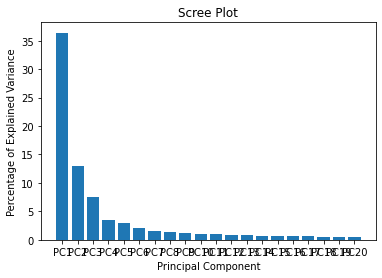

In [9]:
#The following code constructs the Scree plot
per_var = np.round(pca_trapnell.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

In [10]:
print('Explained variation per principal component: {}'.format(pca_trapnell.explained_variance_ratio_))
print('Explained variation from 20 principal component: {}'.format(sum(pca_trapnell.explained_variance_ratio_)))

Explained variation per principal component: [0.36379771 0.12948349 0.0759006  0.03487434 0.02953923 0.02076908
 0.01538555 0.01314346 0.01188277 0.01073692 0.00950919 0.00848627
 0.00767059 0.0069838  0.00666186 0.00588892 0.005846   0.00537703
 0.00484775 0.00471379]
Explained variation from 20 principal component: 0.7714983489202571


In [ ]:
time_start = time.time()

#Graph results of data after PCA dimension reduction 
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=principal_Trapnell_Df['PC1'], y=principal_Trapnell_Df['PC2'],
    data=principal_Trapnell_Df,
    alpha=0.3
)

print('Graphing data after PCA is done Time elapsed {}'.format(time.time()-time_start))

In [ ]:
#PCA plot in 3D
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=principal_Trapnell_Df['PC1'], 
    ys=principal_Trapnell_Df['PC2'],
    zs = principal_Trapnell_Df['PC3'], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [5]:
#tSNE on the data to visualize the clusters

tsne = TSNE(n_components=2, perplexity=50, n_iter=500, learning_rate = 200, init='random')
tsne_results = tsne.fit_transform(df_transpose)

tsne_results.shape

(272, 2)

In [6]:
tSNE_Trapnell_Df = pd.DataFrame(data = tsne_results, columns = ['tSNE-2d-one','tSNE-2d-two'])


<AxesSubplot:xlabel='tSNE-2d-one', ylabel='tSNE-2d-two'>

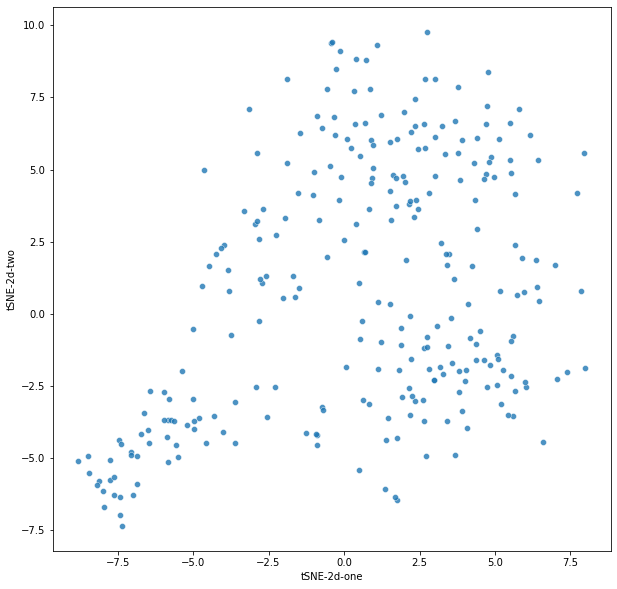

In [7]:
#Plot results of tSNE 
#where output of tSNE is tsne_results

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=tSNE_Trapnell_Df['tSNE-2d-one'], y=tSNE_Trapnell_Df['tSNE-2d-two'],
    data = tSNE_Trapnell_Df,
    legend="full",
    alpha=0.8
)

In [ ]:
#K-means clustering using different cluster groups to initialize

Text(0, 0.5, 'Inertia')

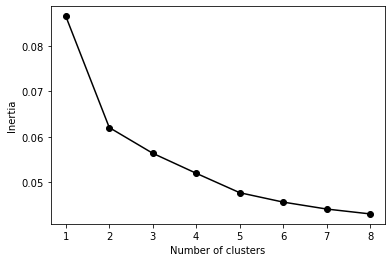

In [16]:
inertias = []
silhouette_scores = []

ks = range(1,9)
data = df_transpose

for k in ks:
    model = KMeans(init="k-means++", n_clusters=k)
    
    model.fit(data)
    labels = model.labels_ 

    inertias.append(model.inertia_)
    #ss = metrics.silhouette_score(data, labels)   # calculate silhouette_score
    #silhouette_scores.append(ss)      # store all the scores
    #print('Parameter:', k, 'Score', ss)
    
# converting the results into a dataframe and plotting them
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [17]:
k_means = KMeans(init="k-means++", n_clusters = 5)

In [18]:
y = k_means.fit(df_transpose)

In [9]:
k_means_cluster_centers = y.cluster_centers_
print(k_means_cluster_centers)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.13590306e-25
  4.13590306e-25 4.13590306e-25]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.03397577e-25
  1.03397577e-25 1.03397577e-25]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.10192730e-25
  3.10192730e-25 3.10192730e-25]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.54076521e-09
  1.54076521e-09 1.54076521e-09]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.20385459e-25
  6.20385459e-25 6.20385459e-25]]


In [25]:
labels = y.labels_ 
print(labels)

[4 4 4 4 1 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 1
 4 4 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 1
 3 2 1 4 2 1 1 1 3 1 3 4 2 1 1 4 1 1 4 4 1 1 1 1 4 2 1 4 4 4 1 4 1 1 2 1 3
 1 1 3 1 1 4 1 1 2 1 4 1 1 1 1 4 3 2 4 1 2 2 1 2 4 4 3 1 1 2 2 2 1 1 3 1 1
 3 4 1 0 1 1 1 1 1 3 3 1 2 1 1 1 1 3 1 3 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 3
 1 1 1 1 1 3 2 1 2 1 1 1 1 0 1 1 1 1 2 4 1 1 1 1 1 2 1 1 1 1 3 1 1 1 1 1 1
 1 1 2 1 1 1 2 1 2 1 1 4 3 1 1 1 1 1 1 1 1 2 1 1 1 1 3 4 1 1 1 1 1 1 1 3 2
 4 1 1 1 1 1 4 4 4 1 1 1 1]


In [57]:
k_means_inertia = k_means.inertia_ 
print(k_means_inertia)

0.047696164711497284


<AxesSubplot:xlabel='tSNE-2d-one', ylabel='tSNE-2d-two'>

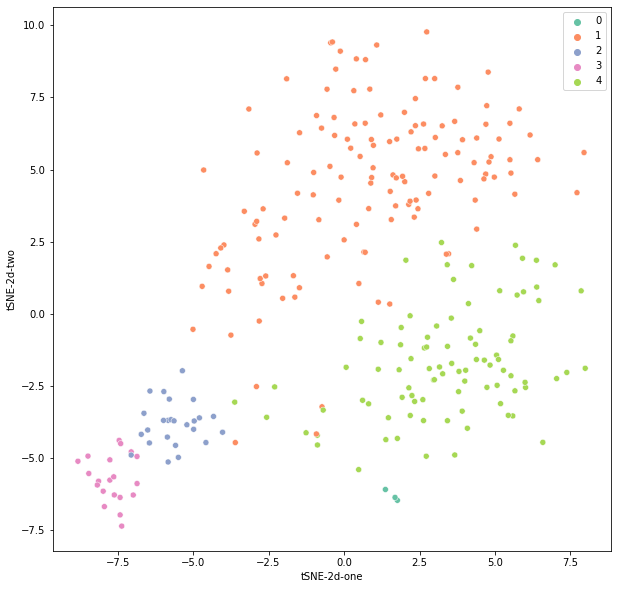

In [26]:
tSNE_Trapnell_Df['Label'] = labels
plt.figure(figsize=(10,10))
sns.scatterplot(
    x=tSNE_Trapnell_Df['tSNE-2d-one'], y=tSNE_Trapnell_Df['tSNE-2d-two'],
    hue= labels,
    palette = "Set2",
    data=tSNE_Trapnell_Df,
    legend="full",
    alpha=1,
)

In [24]:
df_transpose['Label'] = labels

df_transpose['0'] = np.where(df_transpose['Label']==0, 1, 0)
df_transpose['1'] = np.where(df_transpose['Label']==1, 1, 0)
df_transpose['2'] = np.where(df_transpose['Label']==2, 1, 0)
df_transpose['3'] = np.where(df_transpose['Label']==3, 1, 0)
df_transpose['4'] = np.where(df_transpose['Label']==4, 1, 0)


    
df_transpose.shape
df_transpose.head()

,0,1,2,3,4,5,6,7,8,9,...,1065019,1065020,1065021,1065022,Label,0,1,2,3,4
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7,0,0,0,0,0
0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,1,0,0,0
0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,1,0,0,0
0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,1,0,0,0
0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,1,0,0,0


In [26]:
X = df_transpose.drop(['Label','0','1','2','3','4'], axis =1 )
scaler = StandardScaler()
Xstd = scaler.fit_transform(X)
Xstd.shape

MemoryError: Unable to allocate 2.16 GiB for an array with shape (272, 1065023) and data type float64

In [18]:
#Function to run logistic regression on each cluster testing it to see if it is more likely
#to belong to the cluster it was labeled as or some other cluster
def LogRegCluster(Class):
    time_start = time.time()
    y = df_transpose[Class]
    X_train, X_test, y_train, y_test = train_test_split( Xstd, y, test_size=0.2, random_state=4)
    print ('Train set:', X_train.shape,  y_train.shape)
    print ('Test set:', X_test.shape,  y_test.shape)
    #Instantiate model
    logreg = LogisticRegression(penalty ='l2', solver = 'liblinear', class_weight = 'balanced')
    #Fit the model with the data
    logreg.fit(X_train, y_train)
    #Print out predicted y values
    y_pred_train = logreg.predict(X_train)
    y_pred_test = logreg.predict(X_test)
    print('Shape of prediction for training set', y_pred_train.shape)
    print('Shape of prediction for test set',y_pred_test.shape)
    Coeff = logreg.coef_
    max_index = np.argmax(Coeff)
    print('Column of maximum coefficient value is', max_index)
    print('Maximum coefficient value is', Coeff[0,max_index])
    idx = (-Coeff).argsort()[:5]
    print('Sorted Coeff values from largest to smallest', idx)
    ascore = accuracy_score(y_test, y_pred_test)
    print('Accuracy Test Score is ', ascore)
    print('Logistic Regression is done for Cluster Time elapsed {}'.format(time.time()-time_start))
    return Coeff

In [19]:
Cluster0 = LogRegCluster('0')

Train set: (217, 1065023) (217,)
Test set: (55, 1065023) (55,)
Shape of prediction for training set (217,)
Shape of prediction for test set (55,)
Column of maximum coefficient value is 94838
Maximum coefficient value is 0.001565904544454374
Sorted Coeff values from largest to smallest [[ 94838 696525 583857 ...   8691 271628 736239]]
Accuracy Test Score is  0.38181818181818183
Logistic Regression is done for Cluster Time elapsed 56.52060532569885


In [20]:
Cluster1 = LogRegCluster('1')


Train set: (217, 1065023) (217,)
Test set: (55, 1065023) (55,)
Shape of prediction for training set (217,)
Shape of prediction for test set (55,)
Column of maximum coefficient value is 212409
Maximum coefficient value is 0.0016080491989174947
Sorted Coeff values from largest to smallest [[212409 605232  88927 ...  39365 698961 121121]]
Accuracy Test Score is  0.2
Logistic Regression is done for Cluster Time elapsed 71.18307590484619


In [21]:

Cluster2 = LogRegCluster('2')



Train set: (217, 1065023) (217,)
Test set: (55, 1065023) (55,)
Shape of prediction for training set (217,)
Shape of prediction for test set (55,)
Column of maximum coefficient value is 108485
Maximum coefficient value is 0.0013834492286527921
Sorted Coeff values from largest to smallest [[108485 180304   8691 ... 700119 632153    668]]
Accuracy Test Score is  0.9454545454545454
Logistic Regression is done for Cluster Time elapsed 46.51701879501343


In [73]:
Cluster3 = LogRegCluster('3')


Train set: (217, 1065023) (217,)
Test set: (55, 1065023) (55,)
Shape of prediction for training set (217,)
Shape of prediction for test set (55,)
Column of maximum coefficient value is 667
Maximum coefficient value is 1.5536922339238117
Sorted Coeff values from largest to smallest [[   667    668    674 ... 197355  57084  13894]]
Accuracy Test Score is  1.0
Logistic Regression is done for Cluster Time elapsed 19.185578107833862


In [74]:
Cluster4 = LogRegCluster('4')


Train set: (217, 1065023) (217,)
Test set: (55, 1065023) (55,)
Shape of prediction for training set (217,)
Shape of prediction for test set (55,)
Column of maximum coefficient value is 204511
Maximum coefficient value is 0.14002161332126623
Sorted Coeff values from largest to smallest [[204511 108485 188237 ... 304794  94838  13894]]
Accuracy Test Score is  0.9272727272727272
Logistic Regression is done for Cluster Time elapsed 19.050964832305908


In [7]:
from scipy.spatial import distance

df_man = pd.DataFrame(np.zeros((5,5)))

for i in np.arange(len(y.cluster_centers_)):
    for j in np.arange(len(y.cluster_centers_)):
        mandij = distance.cityblock(y.cluster_centers_[i,:], y.cluster_centers_[j,:])
        df_man.iloc[i,j] = mandij

In [16]:
from scipy.spatial import distance

df_allcell = pd.DataFrame(np.zeros(((272, 1065023))))

for i in np.arange(len(df_transpose)):
    for j in np.arange(len(df_transpose)):
        man_cell = distance.cityblock(df_transpose[i,:], df_transpose[j,:])
        df_allcell.iloc[i,j] = man_cell

KeyError: (0, slice(None, None, None))

In [8]:
df_man

,0,1,2,3,4
0,0.000000,0.453060,0.457442,0.399757,0.812639
1,0.453060,0.000000,0.593570,0.627069,0.921011
2,0.457442,0.593570,0.000000,0.371463,0.759257
3,0.399757,0.627069,0.371463,0.000000,0.795173
4,0.812639,0.921011,0.759257,0.795173,0.000000


0
1
0
2
0
3
0
4
1
2
1
3
1
4
2
3
2
4
3
4

{0: array([ 5415.90778385, -5419.84924927]), 1: array([10000.        , -9999.13168979]), 2: array([-5793.40624061,  5793.4287164 ]), 3: array([-82.14957407,  77.4823296 ]), 4: array([-9540.35196918,  9548.06989305])}


(-10517.369567639176,
 10977.017598459008,
 -10976.491768929625,
 10525.429972195128)

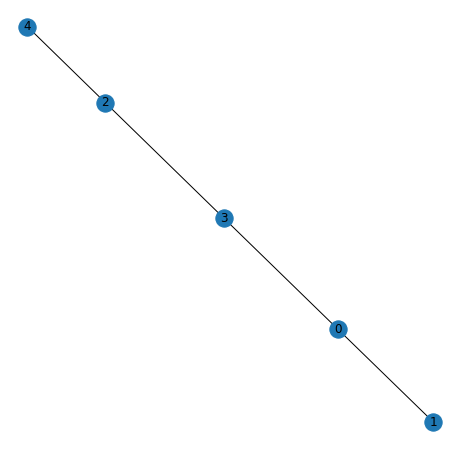

In [10]:
import networkx as nx


fig=plt.figure(figsize=(8,8))

#Generate graph with a center placed for the centroid of each cluster
G = nx.complete_graph(len(np.unique(y.labels_)))
#Calculate the edge length between each cluster using the previously calculated manhattan distance
for u,v in G.edges():
    G[u][v]["weight"]= df_man.iloc[u,v]
    
    #Generate the minimum spanning tree using Networkx built in function
T=nx.minimum_spanning_tree(G)
pos=nx.spring_layout(T,scale=10000)
nx.draw_networkx(T,pos)
#Draw each edge between the different cluster, weighted by the manhattan distance
edge_labels=dict([((u,v,),round(d['weight'],2))
             for u,v,d in T.edges(data=True)])
plt.axis('off')

In [ ]:

Ghd = nx.complete_graph(271)
for u,v in Ghd.edges():
    Ghd[u][v]["weight"]=D[u,v]
Thd=nx.minimum_spanning_tree(Ghd)
colour={'1': 'red', '2': 'blue', '3':'green'}
vals=map(lambda x: colour[x],Trap_labels )
plt.figure(3,figsize=(12,12)) 
pos=nx.spring_layout(Thd,scale=10)
nx.draw(Thd,node_size=50,node_color=vals,pos=pos)
plt.show()

In [98]:
print(y.labels_)
print(len(y.labels_))

[4 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 4
 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 4 1 1 4
 2 0 0 0 0 4 4 4 2 4 2 0 2 4 4 1 4 4 1 0 0 4 4 4 1 0 0 0 1 1 4 1 4 0 0 4 2
 4 1 2 4 4 1 0 4 0 4 0 4 4 4 4 1 2 0 1 4 0 0 4 0 1 1 2 4 4 0 0 0 4 4 2 4 4
 2 1 4 3 4 4 0 4 4 2 2 4 0 4 4 4 4 2 4 2 4 4 0 4 0 4 4 4 0 4 4 4 0 4 4 4 2
 4 4 4 4 4 2 0 4 0 0 4 4 0 3 4 0 4 0 0 0 4 4 4 4 4 2 4 4 4 4 2 4 4 4 4 0 4
 4 4 0 4 4 4 0 0 0 4 0 1 2 4 4 4 4 4 4 1 4 0 4 0 4 4 2 1 4 4 4 4 0 4 4 2 0
 1 4 4 4 4 4 1 1 1 0 4 4 4]
272
